<a href="https://colab.research.google.com/github/ahmadkhan242/PlayingWithMNIST/blob/main/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task - 1


Downloading the given dataset.

In [ ]:
!wget https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip

In [ ]:
# Unzip it.
!unzip trainPart1.zip

## For this task I had used Pytorch library to implement CNN.

In [3]:
# Importing all libraries  required.
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import os,shutil,json
import glob
import torch.utils.data
import math
from skimage import io, transform
from PIL import Image
import torchvision as vision
from torchvision import transforms, datasets
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder

torch.cuda.empty_cache()

In [4]:
# Defining dataset directory 
dataset_dir = "/content/train/"

### The funtion below is used to create train and validation loader.

In [10]:

def prepare_dataset(dataset_path):
  """ Function to create train and validation loader.
    Params:
        dataset_path: path where all images are.
    
    returns: 
        train_loader: train loader with batch size of 64
        validation_loader: validation loader with batch size of 64
        
    Note: Split ratio and batch sizes are pre-defined you can change it in this function.
    """

  labels = os.listdir(dataset_path)

  # Here images are resized and converted to grayscale so that we have data consistency for other tasks
  dataset = ImageFolder(
      dataset_path,
      transforms.Compose([transforms.Resize((32,32)),
                         transforms.ToTensor(),transforms.Grayscale(num_output_channels=1)])
  )
  
  # Validation split 15%
  val_split = int(len(dataset)*0.15)
  train_split = len(dataset) - val_split

  train_dataset, val_dataset = random_split(dataset, [train_split, val_split])

  # to make sure the split is right.
  assert (len(train_dataset)+len(val_dataset)) == len(dataset)

  train_loader = torch.utils.data.DataLoader(train_dataset, 64, shuffle=True)
  validation_loader = torch.utils.data.DataLoader(val_dataset, 64) 

  return (train_loader, validation_loader)


In [11]:
# executing prepare_dataset function
train_loader, validation_loader = prepare_dataset(dataset_dir)

### Data visualisation 

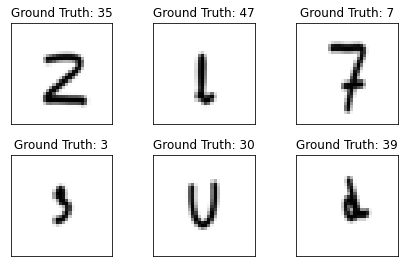

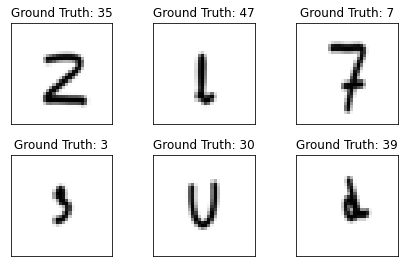

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

### Here the CNN architecture  is defined, the architecture is of ResNet with four layers and one resedual block in each layer.

In [13]:

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=(3,3), bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=(4,4), stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=64):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.linear1 = nn.Linear(512, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.4)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 5)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 5)
        out = torch.flatten(out, 1)
        out = self.linear1(out)
        out = self.dropout1(out)
        out = self.linear2(out)
        out = self.dropout2(out)
        out = self.linear3(out)
        return out


### In the cell below, defined the Model, the loss function, and the Optimizer I have used for this task. 

In [ ]:
model = ResNet(BasicBlock, [1, 1, 1, 1])

criterion = nn.CrossEntropyLoss()
torch.cuda.empty_cache()

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	model = model.cuda()
	optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
	criterion = criterion.cuda()

Tesla P100-PCIE-16GB


### Here the train function is defined for training the model defined above.
### Please follow the comment to guide your self in the train function.

In [ ]:
%%time
# Loss and accuracy list are defined, these lists are used for graph.
train_loss_list = []
val_loss_list = []
epc_list = []
train_acc_list = []
val_acc_list = []

def train():
  # best_valid_loss is defined so as to save the best validation loss which is lowest one.
  best_valid_loss = float('Inf')

  print("Training Started !!!")
  for i in range(25):
    training_loss = 0
    tcorrect = 0
    ttotal = 0
    model.train()
    for features, labels in train_loader:
      # Label and features assigning
      features, labels = Variable(features.cuda()), Variable(labels.cuda())
      optimizer.zero_grad()

      # Output collection from model
      outputs = model(features.float())
      
      # Loss calculation and updation
      losss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())
      losss.backward()
      optimizer.step()
      training_loss += losss.item()

      # Prediction
      _, pred = torch.max(outputs, 1)
      ttotal+= labels.reshape(-1).size(0)
      tcorrect+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
  
    # Validation step starts from here.
    validation_loss = 0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
      for features, labels in validation_loader:
        # Label and features assigning
        features, labels = Variable(features.cuda()), Variable(labels.cuda())

        # Output collection from model
        outputs = model(features.float())
        
        # Loss calculation, here we skip the backward and 
        # optimizer step as we do not update weights while validating a model
        loss = criterion(outputs.cuda(), labels.type(torch.LongTensor).cuda())

        # Prediction
        _, pred = torch.max(outputs, 1)
        total+= labels.reshape(-1).size(0)
        correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
        validation_loss += loss.item()


    train_loss_list.append(training_loss/len(train_loader))
    val_loss_list.append(validation_loss/len(validation_loader))
    epc_list.append(i)
    train_acc_list.append(100*(tcorrect/ttotal))
    val_acc_list.append(100*(correct/total))

    # Logic was defined so as to save the weights of mnist_model when validation loss is lowest.
    if best_valid_loss > validation_loss:
        best_valid_loss = validation_loss 
        # Saving Best Pre-Trained Model as .pth file
        torch.save(model, "/content/drive/MyDrive/MNIST/final_task.pth")
        
    print("Epoch {} - \nTraning loss: {}".format(i+1, training_loss/len(train_loader)))
    print("Validation loss: {}".format( validation_loss/len(validation_loader)))
    print("Trainig Accuracy: {}".format( 100*(tcorrect/ttotal)))
    print("Validation Accuracy: {}".format(100*(correct/total)))

train()

print("Training Complete")

Training Started !!!
Epoch 1 - 
Traning loss: 3.964891932227395
Validation loss: 4.287020126978557
Trainig Accuracy: 5.218216318785579
Validation Accuracy: 1.0752688172043012
Epoch 2 - 
Traning loss: 3.1603120601538457
Validation loss: 3.0344272454579673
Trainig Accuracy: 14.468690702087287
Validation Accuracy: 19.35483870967742
Epoch 3 - 
Traning loss: 2.5492292534221304
Validation loss: 2.559219320615133
Trainig Accuracy: 24.09867172675522
Validation Accuracy: 29.03225806451613
Epoch 4 - 
Traning loss: 2.0560514529546103
Validation loss: 2.0994941790898642
Trainig Accuracy: 36.29032258064516
Validation Accuracy: 37.903225806451616
Epoch 5 - 
Traning loss: 1.668349807912653
Validation loss: 3.16666313012441
Trainig Accuracy: 48.007590132827325
Validation Accuracy: 25.0
Epoch 6 - 
Traning loss: 1.380571430379694
Validation loss: 2.5826780796051025
Trainig Accuracy: 55.02846299810247
Validation Accuracy: 28.763440860215056
Epoch 7 - 
Traning loss: 1.1930692159768306
Validation loss: 1.0

### Graph plot of training loss and validation loss with no of epochs.


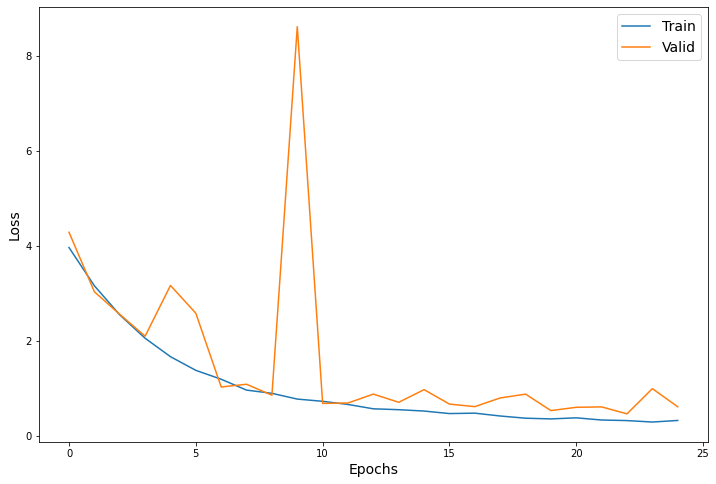

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(epc_list, train_loss_list, label='Train')
plt.plot(epc_list, val_loss_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Graph plot of training accuracy and validation accuracy with no of epochs.

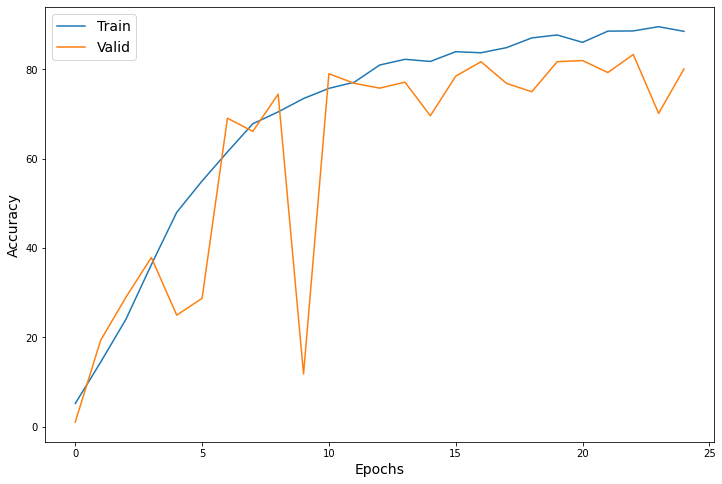

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(epc_list, train_acc_list, label='Train')
plt.plot(epc_list, val_acc_list, label='Valid')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Conclusion  - 
* `Dataset` -   
### Dataset information  -  
  * No of classes - 62
  * No of samples each - 40 
  * Total samples - 2480

  ### Validation split of 15% was used.
  ### Pre-Processing  
  * Images were resized to 32x32 to reduce computational power.
  * Images were converted to grayscale(single channel) so that we have data consistency for other tasks.
* `Model` - For this task Resnet architecture  was used with 4 layers and 1 resudual block in each layer, and finally three linear layers where used with dropout in first linear layer and second linear layer.

  <details> 
    <summary>Complete Architecture summary</summary>
    
  ```bash
        ----------------------------------------------------------------
                Layer (type)               Output Shape         Param #
        ================================================================
                    Conv2d-1           [-1, 64, 32, 32]             576
               BatchNorm2d-2           [-1, 64, 32, 32]             128
                    Conv2d-3           [-1, 64, 32, 32]          36,864
               BatchNorm2d-4           [-1, 64, 32, 32]             128
                    Conv2d-5           [-1, 64, 32, 32]          36,864
               BatchNorm2d-6           [-1, 64, 32, 32]             128
                BasicBlock-7           [-1, 64, 32, 32]               0
                    Conv2d-8          [-1, 128, 32, 32]          73,728
               BatchNorm2d-9          [-1, 128, 32, 32]             256
                   Conv2d-10          [-1, 128, 32, 32]         147,456
              BatchNorm2d-11          [-1, 128, 32, 32]             256
                   Conv2d-12          [-1, 128, 32, 32]           8,192
              BatchNorm2d-13          [-1, 128, 32, 32]             256
               BasicBlock-14          [-1, 128, 32, 32]               0
                   Conv2d-15          [-1, 256, 32, 32]         294,912
              BatchNorm2d-16          [-1, 256, 32, 32]             512
                   Conv2d-17          [-1, 256, 32, 32]         589,824
              BatchNorm2d-18          [-1, 256, 32, 32]             512
                   Conv2d-19          [-1, 256, 32, 32]          32,768
              BatchNorm2d-20          [-1, 256, 32, 32]             512
               BasicBlock-21          [-1, 256, 32, 32]               0
                   Conv2d-22            [-1, 512, 6, 6]       1,179,648
              BatchNorm2d-23            [-1, 512, 6, 6]           1,024
                   Conv2d-24            [-1, 512, 6, 6]       2,359,296
              BatchNorm2d-25            [-1, 512, 6, 6]           1,024
                   Conv2d-26            [-1, 512, 6, 6]         131,072
              BatchNorm2d-27            [-1, 512, 6, 6]           1,024
               BasicBlock-28            [-1, 512, 6, 6]               0
                   Linear-29                  [-1, 256]         131,328
                  Dropout-30                  [-1, 256]               0
                   Linear-31                  [-1, 128]          32,896
                  Dropout-32                  [-1, 128]               0
                   Linear-33                   [-1, 64]           8,256
        ================================================================
        Total params: 5,069,440
        Trainable params: 5,069,440
        Non-trainable params: 0
        ----------------------------------------------------------------
        Input size (MB): 0.00
        Forward/backward pass size (MB): 25.49
        Params size (MB): 19.34
        Estimated Total Size (MB): 44.83
        ----------------------------------------------------------------

  ```
</details> 

* `Training Methodology` -
  * Epoch = 25     
  * Learning rate - 0.001.
  * weight decay - 0.0001.
  * Training batch size = 64
  * Validation batch size = 64
  * Batch Normalisation and Dropout of 0.3 and 0.4 where used.  

* `Results` -  
  * Max Training accuracy - 89.6
  * Max Validation accuracy - 83.4
  * Training accuracy on last epoch - 88.5   
  * Validation accuracy on last epoch - 80.1

* `Refrence`
  * https://github.com/pytorch/vision